In [8]:
# Import program libraries
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Problem 1 Import the dataset
data1 = np.loadtxt('usincmoms.txt', delimiter = '\t')
pct = data1[:,0]
midpt = data1[:,1]

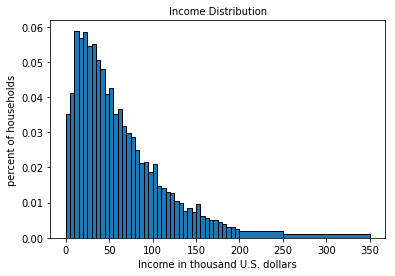

In [10]:
# (a)
# Adjust the weight of the last two bars.
weights = pct[:]
weights[40] = pct[40]/10
weights[41] = pct[41]/20
bins = list(range(0,205,5)) + [250,350]

# Plot all.
plt.hist(midpt/1000, bins = bins, weights = weights, edgecolor='black')
plt.title('Income Distribution', fontsize=10)
plt.xlabel('Income in thousand U.S. dollars')
plt.ylabel('percent of households')
plt.show()

In [11]:
# (b)
# Define the model moments. We calculate the probability of each bin under the log normal distribution assumption.
upper = np.append(midpt[0:40]/1000+2.5, [midpt[40]/1000+25, midpt[41]/1000+50])
lower = np.append(midpt[0:40]/1000-2.5, [midpt[40]/1000-25, midpt[41]/1000-50])

def model_moments(mu,sigma):
    prob = sts.lognorm.cdf(upper, sigma, scale = np.exp(mu)) - sts.lognorm.cdf(lower, sigma, scale = np.exp(mu))
    return prob

# Define the error vector.
def err_vec(xvals, mu, sigma):
    moms_model = model_moments(mu,sigma)
    moms_data = xvals[:]
    err_vec = moms_model - moms_data
    return err_vec

# Define the criteria function.
def crit(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    crit_val = np.dot(np.dot(np.transpose(err), W), err)
    return crit_val

In [12]:
# Set initial values.
mu_init = np.log(data1.mean())
sigma_init = np.log(data1.std())
params_init = np.array([mu_init, sigma_init])

# Define a weighted matrix.
W = np.diag(pct[:])

# Conduct GMM estimation.
gmm_args = (pct, W)

result = opt.minimize(crit, params_init, args = gmm_args, method = 'L-BFGS-B', bounds = ((None,None),(1e-10,None)))
mu_gmm, sigma_gmm = result.x
print(result)

      fun: 3.2756897553833465e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.66691137e-06,   3.51332936e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 123
      nit: 18
   status: 0
  success: True
        x: array([ 3.97537496,  1.04467814])


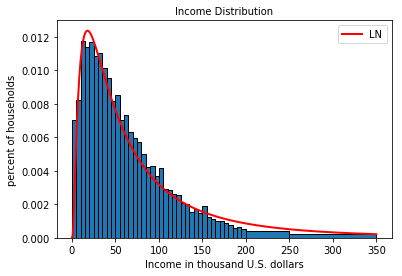

In [14]:
# Plot the result.
pts = np.linspace(0, 350, 500)
plt.hist(midpt/1000, bins = bins, weights = weights/5, edgecolor='black')
plt.plot(pts, sts.lognorm.pdf(pts, sigma_gmm, scale = np.exp(mu_gmm)), color = 'r', linewidth = 2, label = 'LN')
plt.title('Income Distribution', fontsize=10)
plt.xlabel('Income in thousand U.S. dollars')
plt.ylabel('percent of households')
plt.legend(loc = 'upper right')
plt.show()

In [19]:
# (c)
# Repeat the same exercise with the gamma distribution.
# Define the model moments.
def model_moments(alpha,beta):
    prob = sts.gamma.cdf(upper, alpha, scale = beta) - sts.gamma.cdf(lower, alpha, scale = beta) 
    return prob

# Define the error vector.
def err_vec(xvals, alpha, beta):
    moms_model = model_moments(alpha,beta)
    moms_data = xvals[:]
    err_vec = moms_model - moms_data
    return err_vec

# Define the criteria function.
def crit(params, *args):
    alpha, beta = params
    xvals, W = args
    err = err_vec(xvals, alpha, beta)
    crit_val = np.dot(np.dot(np.transpose(err), W), err)
    return crit_val

In [20]:
# Set the initial values.
alpha_init = 3
beta_init = 20
params_init = np.array([alpha_init, beta_init])

# Conduct GMM estimation.
result = opt.minimize(crit, params_init, args = (gmm_args), method = 'L-BFGS-B', bounds = ((1e-10,None),(1e-10,None)))
alpha_gmm, beta_gmm = result.x
print(result)

      fun: 6.6302605592292703e-06
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.87498559e-07,  -4.75273575e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 54
      nit: 16
   status: 0
  success: True
        x: array([  1.43549852,  44.19498844])


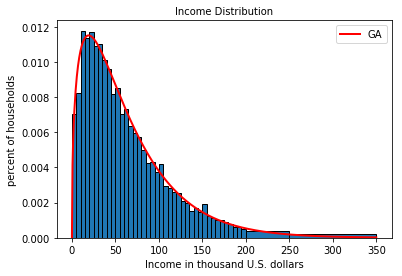

In [21]:
# Plot the result.
plt.hist(midpt/1000, bins = bins, weights = weights/5, edgecolor='black')
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm, scale = beta_gmm), color = 'r', linewidth = 2, label = 'GA')
plt.title('Income Distribution', fontsize=10)
plt.xlabel('Income in thousand U.S. dollars')
plt.ylabel('percent of households')
plt.legend(loc = 'upper right')
plt.show()

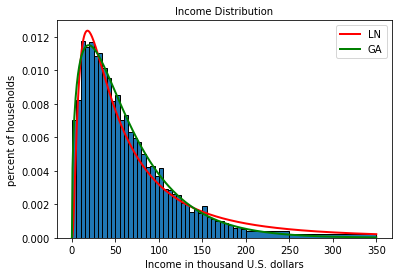

In [22]:
# (d)
# Plot the both estimation results.
plt.hist(midpt/1000, bins = bins, weights = weights/5, edgecolor='black')
plt.plot(pts, sts.lognorm.pdf(pts, sigma_gmm, scale = np.exp(mu_gmm)), color = 'r', label = 'LN', linewidth = 2)
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm, scale = beta_gmm), color = 'g', label = 'GA', linewidth = 2)
plt.title('Income Distribution', fontsize=10)
plt.xlabel('Income in thousand U.S. dollars')
plt.ylabel('percent of households')
plt.legend(loc = 'upper right')
plt.show()

In [331]:
# We can compare these two results by the values of minimized functions. Since the estimation with the gamma
# distribution records the lower value, we can conclude that the estmation in (c) provides the better result.

In [24]:
# (e)
# First, estimate the paremeters using the identity matrix.
result_1 = opt.minimize(crit, params_init, args = (pct, np.identity(data1.shape[0])), method = 'L-BFGS-B', bounds = ((1e-10,None),(1e-10,None)))
alpha_1, beta_1 = result_1.x
print(result_1)

# Compute the two-step estimator.
err_vec_1 = np.reshape(err_vec(pct, alpha_1, beta_1),(42,1))
omega = (err_vec_1 @ err_vec_1.T) / data1.shape[0] 
W_2_step = np.linalg.pinv(omega)

# Estimate the parameters using the two-step estimator.
params_init = np.array([alpha_1, beta_1])
result = opt.minimize(crit, params_init, args = (pct, W_2_step), method = 'L-BFGS-B', bounds = ((1e-10,None),(1e-10,None)))
alpha_2_step, beta_2_step = result.x
print(result)

      fun: 0.0003835718976327242
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.63410170e-06,  -1.31692617e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 54
      nit: 15
   status: 0
  success: True
        x: array([  1.48127253,  41.29450577])
      fun: 2.3822868627010248e-12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.16616381e-05,   1.90787120e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 12
   status: 0
  success: True
        x: array([  3.99118795,  22.69840273])


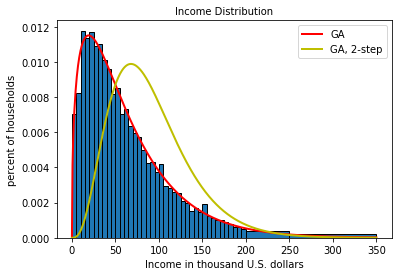

In [25]:
# To see the goodness of fit, we plot this result.
plt.hist(midpt/1000, bins = bins, weights = weights/5, edgecolor='black')
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm, scale = beta_gmm), color = 'r', label = 'GA', linewidth = 2)
plt.plot(pts, sts.gamma.pdf(pts, alpha_2_step, scale = beta_2_step), color = 'y', label = 'GA, 2-step', linewidth = 2)
plt.title('Income Distribution', fontsize=10)
plt.xlabel('Income in thousand U.S. dollars')
plt.ylabel('percent of households')
plt.legend(loc = 'upper right')
plt.show()

In [334]:
# Since we used the different weighted matrix, we cannot directly compare these two results, despite the fact that
# the estimation with the two-step estimator provides the lower value of the criterion function. Also, we cannot
# determine which estimation fits with the data better from the graph either.

In [30]:
# Problem 2
# Import the data.
data2 = np.loadtxt('MacroSeries.txt', delimiter = ',')
c_t = data2[:,0]
k_t = data2[:,1]
w_t = data2[:,2]
r_t = data2[:,3]

In [37]:
# Back out z_t using Equation (4)
def eqn4(k_t, r_t, alpha):
    z = np.log(r_t / (alpha*(k_t **(alpha-1))))
    z_t = z[0:99]
    z_t_1 = z[1:100]
    return z_t,z_t_1

# Define the data moments.
def data_moments(c_t, k_t, w_t, r_t, alpha, beta, rho, mu):
    z_t, z_t_1 = eqn4(k_t, r_t, alpha)
    mom1 = z_t_1 - rho*z_t - (1-rho)*mu
    mom2 = (z_t_1 - rho*z_t - (1-rho)*mu)*z_t
    kt = k_t[0:99]
    kt_1 = k_t[1:100]
    ct = c_t[0:99]
    ct_1 = c_t[1:100]
    mom3 = beta*alpha*np.exp(z_t_1)*(kt_1**(alpha-1))*(ct/ct_1)-1
    wt = w_t[0:99]
    mom4 = (beta*alpha*np.exp(z_t_1)*(kt_1**(alpha-1))*(ct/ct_1)-1)*wt
    data_moments = np.array([np.mean(mom1), np.mean(mom2), np.mean(mom3), np.mean(mom4)])
    return data_moments

# Define model moments (they are all zero by assumption).
def model_moments(c_t, k_t, w_t, r_t, alpha, beta, rho, mu):
    return np.zeros(4)

# Define the error vector.
def err_vec(c_t, k_t, w_t, r_t, alpha, beta, rho, mu):
    datamoments = data_moments(c_t, k_t, w_t, r_t, alpha, beta, rho, mu)
    err_vec = (datamoments - model_moments(c_t, k_t, w_t, r_t, alpha, beta, rho, mu))
    return err_vec

# Define the criterion function.
def crit(params, *args):
    alpha, beta, rho, mu = params
    c_t, k_t, w_t, r_t, W = args
    err = err_vec(c_t, k_t, w_t, r_t, alpha, beta, rho, mu)
    crit_val = err @ W @ err.T
    return crit_val

In [42]:
# Set the initial value.
alpha_init = 0.3
beta_init = 0.9
rho_init = 0.9
mu_init = 11
params_init = np.array([alpha_init, beta_init, rho_init, mu_init])

# Conduct GMM estimation.
W = np.eye(4)
gmm_args = (c_t, k_t, w_t, r_t, W)
result = opt.minimize(crit, params_init, args=(gmm_args), method = 'L-BFGS-B', bounds = ((1e-10, 1-1e-10),(1e-10, 1-1e-10),(-1+1e-10, 1-1e-10),(1e-10, None)))
alpha_gmm, beta_gmm, rho_gmm, mu_gmm, = result.x
print(result)

      fun: 0.0027670229227851253
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.88994066e-03,   6.04704275e+01,  -1.72918103e-04,
         4.38701245e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 340
      nit: 38
   status: 0
  success: True
        x: array([  0.36921265,   0.99      ,   0.94206062,  11.00062275])
